<a href="https://colab.research.google.com/github/ptran1203/traffic_sign_detection/blob/main/traffic_signs_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, output

# drive.mount('/content/drive')
 
%cd "/content"
!rm -rf traffic_sign_detection
!git clone https://github.com/ptran1203/traffic_sign_detection
%cd traffic_sign_detection
output.clear()

### Download data and train model

In [2]:
# !./download_data.sh
# !python3 train.py --input /content/dataset/za_traffic_2020/traffic_train/images\
#                   --backbone resnet50\
#                   --batch-size 4\
#                   --checkpoint-dir /content/weights\
#                   --init-from weights/weight_resnet50.h5\

### Run prediction

In [ ]:
!python3 prediction.py --input images/105.png\
                       --output /content/submission.json\
                       --weight weights/weight_densenet121.h5\
                       --scales 1024\
                       --tiling
                    #    --weight /content/weights/weight_densenet121.h5\

In [4]:
from prediction import get_inference_model, Prediction
import cv2
import utils

weight = 'weights/weight_densenet121.h5'
backbone = weight.split("_")[-1].replace(".h5", "")

predictor = Prediction(get_inference_model(weight, backbone))

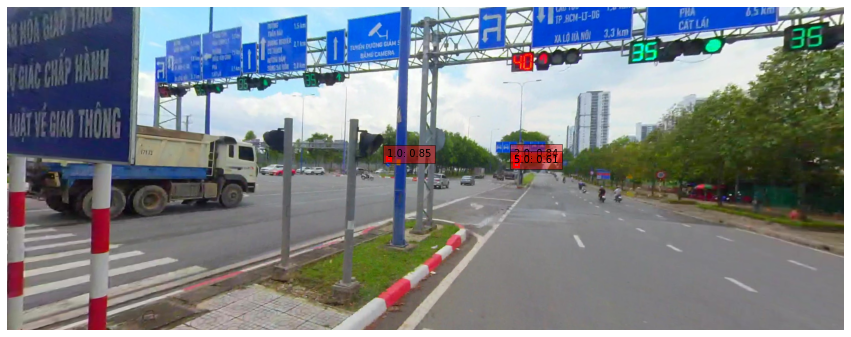

In [5]:
file_path = 'images/105.png'
image, boxes, scores, classes = predictor.detect_single_image(
        cv2.imread(file_path)[..., ::-1], tiling=True
    )
utils.visualize_detections(image, boxes, classes, scores)